In [32]:
import numpy as np
import pandas
import pickle
import matplotlib.pyplot as plt
import torch

In [33]:
data = np.array(pickle.load(open('../testing_scripts/gym_states.pkl', 'rb')))

In [34]:
states, rewards = [], []
for d in data: 
    states.append(d[0])
    rewards.append(d[1])
    
states = np.array(states)
rewards = np.array(rewards)

In [35]:
states.max(axis=0)

array([-3.5958290e-03,  1.3944238e+00, -8.1197381e-02, -5.2798580e-08,
        4.8314162e-02,  4.4783729e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 52., 17.]),
 array([-100.        ,  -88.69091847,  -77.38183695,  -66.07275542,
         -54.7636739 ,  -43.45459237,  -32.14551085,  -20.83642932,
          -9.5273478 ,    1.78173373,   13.09081525]),
 <a list of 10 Patch objects>)

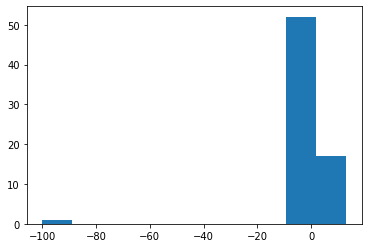

In [36]:
plt.hist(rewards)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 87.]),
 array([-2.4200225e+04, -2.1780928e+04, -1.9361633e+04, -1.6942336e+04,
        -1.4523040e+04, -1.2103744e+04, -9.6844482e+03, -7.2651519e+03,
        -4.8458555e+03, -2.4265593e+03, -7.2632298e+00], dtype=float32),
 <a list of 10 Patch objects>)

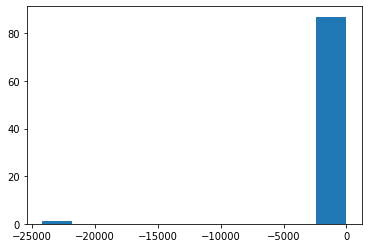

In [28]:
r_mu_prior, r_sigma_prior = torch.Tensor([10.0]), torch.Tensor([0.5])
        
reward_neg_surprise = torch.distributions.Normal(r_mu_prior, r_sigma_prior).log_prob(torch.as_tensor(rewards).float())
plt.hist(reward_neg_surprise)

In [29]:
r_mu_prior.dtype

torch.float32

In [30]:
torch.as_tensor(rewards).dtype

torch.float64

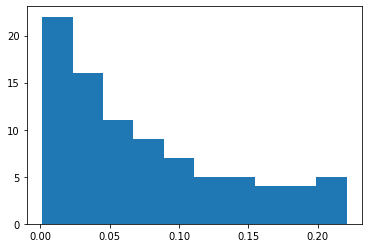

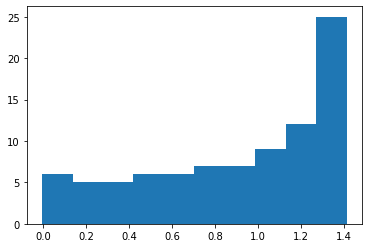

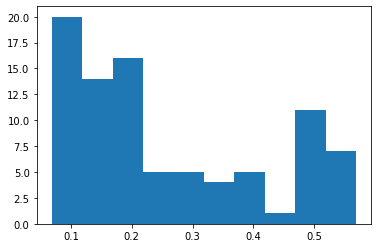

In [31]:


for i in range(3):
    plt.hist(states[:,i])
    plt.show()

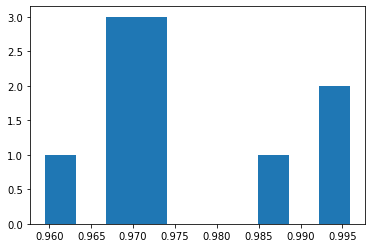

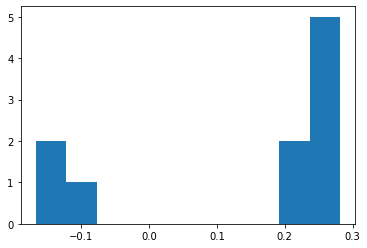

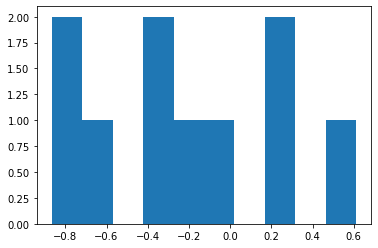

In [7]:
# plotting by different reward bins
mask = np.logical_and(rewards < 0.0 , rewards > -0.1)
for i in range(3):
    plt.hist(states[mask,i])
    plt.show()

In [8]:
# need to scale all states to between 0 and 1. 

'''states[:,0] = (states[:,0]+1)/2.1
states[:,1] = (states[:,1]+1)/2.1
states[:,2] = (states[:,2]+8.1)/16.1'''

'states[:,0] = (states[:,0]+1)/2.1\nstates[:,1] = (states[:,1]+1)/2.1\nstates[:,2] = (states[:,2]+8.1)/16.1'

In [9]:
for i in range(3):
    print(states[:,i].max(), states[:,i].min())


0.9999998127357386 -0.9999131817219319
0.9979794117760017 -0.9999732240626072
7.742699200063698 -8.0


## Fit a neural network to the distribution

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

num_states = 3
num_g = 2

class RewardModel(nn.Module):
    def __init__(self, node_size, act_fn="relu"):
        super().__init__()
        self.act_fn = getattr(torch, act_fn)
        self.fc_1 = nn.Linear(1, node_size)
        self.fc_2 = nn.Linear(node_size, node_size)
        
        self.fc_3 = nn.Linear(node_size, 3*num_states*num_g)

    def forward(self, reward):
        out = self.act_fn(self.fc_1(reward))
        out = self.act_fn(self.fc_2(out))
        out = self.fc_3(out)
        return out

In [11]:
inputs = torch.Tensor(rewards).unsqueeze(1)#[:20]
states = torch.Tensor(states)#[:20]

In [59]:
model = RewardModel(10)
optimizer = optim.Adam(model.parameters(), lr=0.03)

epoch 0 loss is: 7.7127275466918945
epoch 100 loss is: 2.205075979232788
epoch 200 loss is: 0.7353912591934204
epoch 300 loss is: 0.5647748708724976
epoch 400 loss is: 0.36981600522994995
epoch 500 loss is: 0.3479745388031006
epoch 600 loss is: 0.27998557686805725
epoch 700 loss is: 0.27430373430252075
epoch 800 loss is: 0.2568226158618927
epoch 900 loss is: 0.20909608900547028
epoch 1000 loss is: 0.1993567794561386
epoch 1100 loss is: 0.3350347876548767
epoch 1200 loss is: 0.20085479319095612
epoch 1300 loss is: 0.18097378313541412
epoch 1400 loss is: 0.1750197559595108
epoch 1500 loss is: 0.21014313399791718
epoch 1600 loss is: 0.17144185304641724
epoch 1700 loss is: 0.16728031635284424
epoch 1800 loss is: 0.18586204946041107
epoch 1900 loss is: 0.3203865885734558
Finished Training


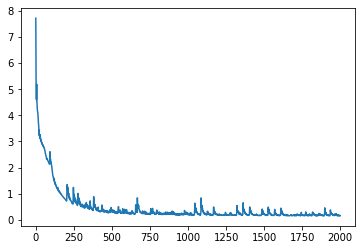

In [60]:

num_epochs = 2000

losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    
    stride = 2 * 3
    
    logpi = outputs[:,:stride].view(-1, num_g, num_states)
    mus = outputs[:,stride:2*stride].view(-1, num_g, num_states)
    logsigmas = outputs[:,2*stride:3*stride].view(-1, num_g, num_states)
    
    log_probs = torch.log_softmax(logpi, dim=-2)
    
    normal_dist = torch.distributions.Normal(mus, logsigmas.exp()) # for every gaussian in each latent dimension. 
    #print('MDRNN TEST. WHAT ARE THE DIMENSIONS OF THESE????', logpi.shape, mus.shape, latent_deltas.shape)
    g_log_probs = log_probs + normal_dist.log_prob(states.unsqueeze(-2)) # how far off are the next obs? 
    # sum across the gaussians, need to do so in log space: 
    loss = - torch.logsumexp(g_log_probs, dim=-2) 
    #outputs = outputs.exp() 
    #loss = - torch.distributions.Beta(outputs[:,0:3], outputs[:,3:] ).log_prob(states) # criterion(outputs, labels)
    
    loss = loss.sum(-1).mean()
    #print( 'loss for epoch', loss.item())
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    # print statistics
    if epoch %100 ==0:
        print('epoch', epoch, 'loss is:', loss.item())
        #print('first series of outputs, then states', outputs[0], states[0], inputs[0])

print('Finished Training')
plt.plot(losses)

In [31]:
# get the mode from the distribution

In [33]:
test_rewards = [-8, -6, -4, -2, -0.01, -0.04]
outputs = model(torch.Tensor(test_rewards).unsqueeze(1)) #.exp()
logpi = outputs[:,:stride].view(-1, num_g, num_states)
mus = outputs[:,stride:2*stride].view(-1, num_g, num_states)
logsigmas = outputs[:,2*stride:3*stride].view(-1, num_g, num_states)
sigmas = logsigmas.exp()

In [43]:
logpi.shape

torch.Size([6, 2, 3])

In [44]:
mus.shape

torch.Size([6, 2, 3])

In [63]:
slice(5,10)

slice(5, 10, None)

In [45]:
g_probs = torch.distributions.Categorical(probs=torch.exp(logpi.squeeze()).permute(0,2,1))
which_g = g_probs.sample()
mus_g, sigmas_g = torch.gather(mus.squeeze(), 1, which_g.unsqueeze(1)).squeeze(), torch.gather(sigmas.squeeze(), 1, which_g.unsqueeze(1)).squeeze()

torch.distributions.Normal(mus_g,sigmas_g ).sample([1])

tensor([[[-0.7108, -0.8021, -6.8458],
         [-0.5242,  0.9487, -5.0007],
         [ 0.2871, -0.7871,  4.1928],
         [ 0.6253, -0.7210,  4.0775],
         [ 1.0020, -0.2555,  0.3189],
         [ 0.9842,  0.2467,  0.5905]]])

In [46]:
which_g.shape

torch.Size([6, 3])

In [40]:
which_g

tensor([[0, 1, 0],
        [1, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 0, 0]])

In [50]:
#g_probs = torch.distributions.Categorical(probs=torch.exp(logpi.squeeze()).permute(0,2,1))
which_g = logpi.argmax(-2)
mus_g, sigmas_g = torch.gather(mus.squeeze(), 1, which_g.unsqueeze(1)).squeeze(), torch.gather(sigmas.squeeze(), 1, which_g.unsqueeze(1)).squeeze()

mus_g

tensor([[-0.1226,  0.8010, -6.1278],
        [-0.5460,  0.9302, -5.6293],
        [-0.1614,  0.9032, -4.4893],
        [ 0.3303,  0.7980, -3.0281],
        [ 0.9780, -0.1721, -0.5114],
        [ 0.9689, -0.1952, -0.5121]], grad_fn=<SqueezeBackward0>)

In [49]:
logpi.argmax(-2)

tensor([[0, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 1],
        [0, 0, 1]])

samps size is: torch.Size([1000, 6, 3])
test reward is: -8


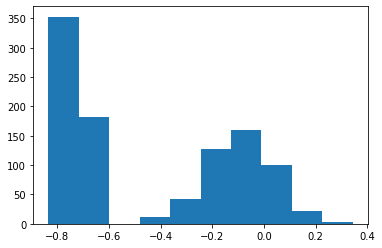

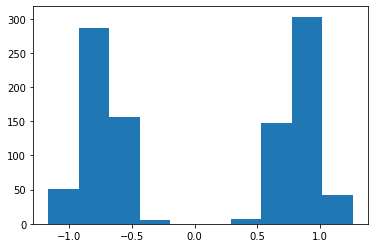

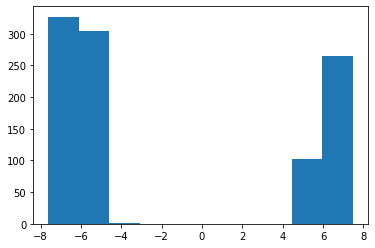

test reward is: -6


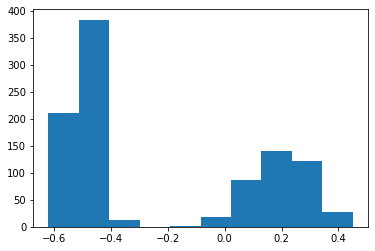

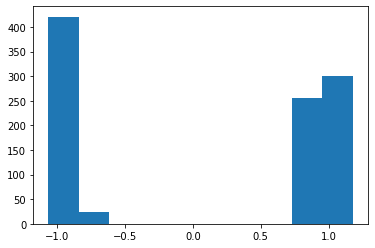

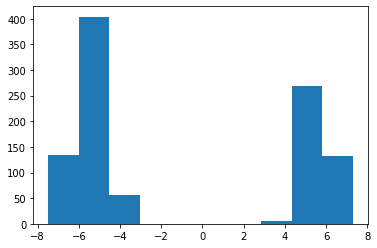

test reward is: -4


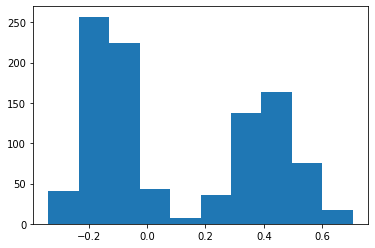

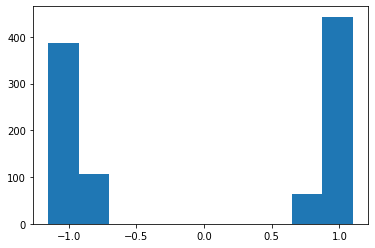

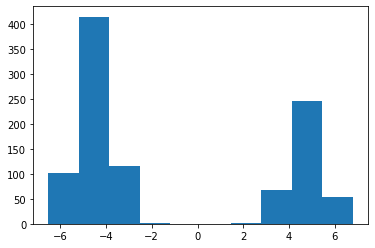

test reward is: -2


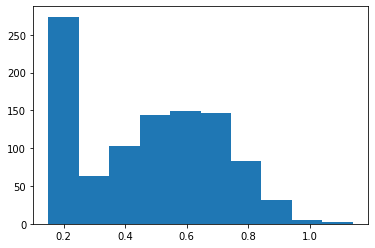

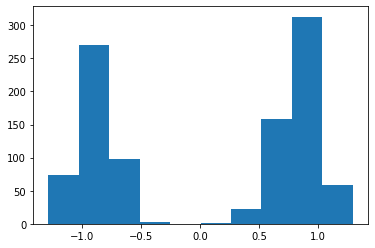

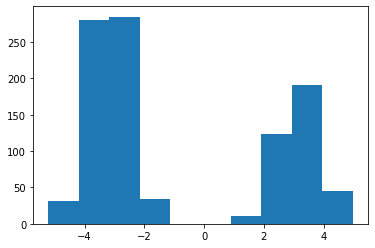

test reward is: -0.01


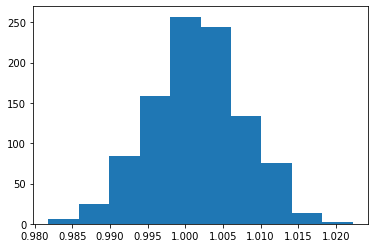

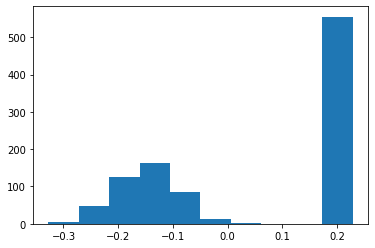

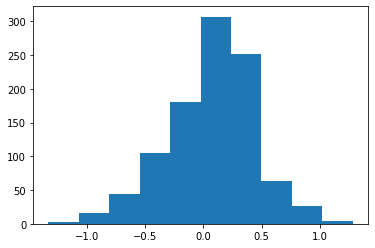

test reward is: -0.04


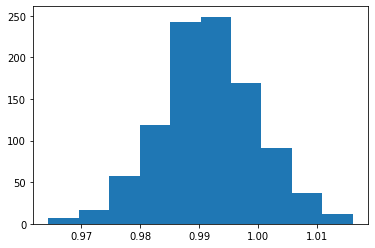

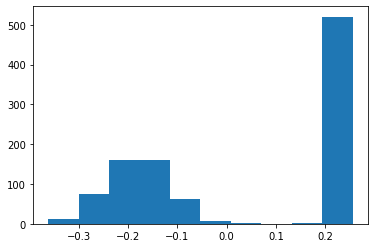

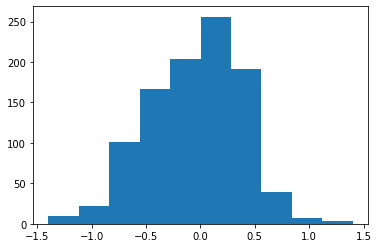

In [24]:

samps = []
for k in range(1000):
    g_probs = torch.distributions.Categorical(probs=torch.exp(logpi.squeeze()).permute(0,2,1))
    which_g = g_probs.sample()
    mus_g, sigmas_g = torch.gather(mus.squeeze(), 1, which_g.unsqueeze(1)).squeeze(), torch.gather(sigmas.squeeze(), 1, which_g.unsqueeze(1)).squeeze()
    sa = torch.distributions.Normal(mus_g,sigmas_g ).sample([1])
    #print('sa', sa.shape)
    samps.append(sa.squeeze())
samps = torch.stack(samps)
#samps = torch.distributions.Beta(res[r,:3],res[r,3:] ).sample([1000])
print('samps size is:', samps.shape)
for r in range(6):
    print('test reward is:',test_rewards[r])
    for i in range(3):
        plt.hist(samps[:,r,i])
        plt.show()
    print('=========')

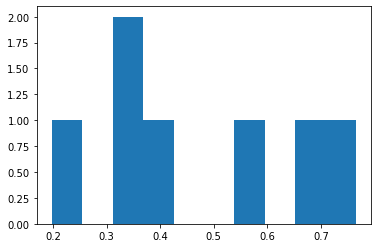

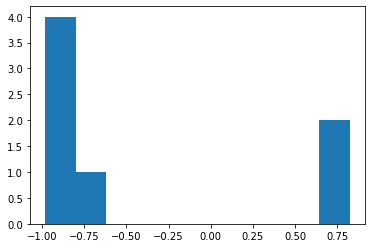

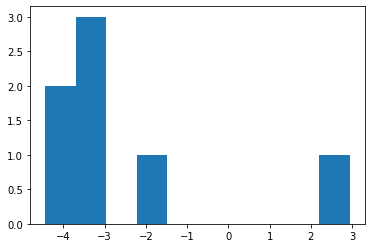

In [18]:
# plotting by different reward bins
mask = np.logical_and(rewards < -1.9 , rewards > -2.3)
for i in range(3):
    plt.hist(states[mask,i])
    plt.show()

# multivariate with covariance matrix

In [26]:
np.expand_dims(rewards,1).shape

(200, 1)

In [27]:
states.shape

torch.Size([200, 3])

In [28]:
sr = np.concatenate([states,np.expand_dims(rewards,1)], axis=1)

In [29]:
mus = sr.mean(axis=0)
mus

array([ 0.25759256,  0.04116807, -0.85134329, -4.13237383])

In [30]:
sr[:,-1].argmax()

0

In [33]:
sr[100:105]

array([[ 0.69378781, -0.72017944, -2.79928017, -1.0322417 ],
       [ 0.55697513, -0.83052921, -3.51992369, -1.43155908],
       [ 0.3608104 , -0.93263918, -4.43205023, -2.20321623],
       [ 0.1265475 , -0.99196053, -4.84497976, -3.4119423 ],
       [-0.15194434, -0.98838907, -5.58845758, -4.43225475]])

In [42]:
sr[-5:]

array([[ -0.85682186,   0.51561255,   6.57430579,  -8.92827924],
       [ -0.98122235,   0.19288003,   6.9525191 , -11.08147816],
       [ -0.98537324,  -0.17041005,   7.30684485, -13.5234398 ],
       [ -0.86792712,  -0.49669156,   6.97073859, -14.16388703],
       [ -0.65559451,  -0.75511313,   6.72087891, -11.73367566]])

In [32]:
sigmas = np.cov(sr, rowvar=False)
sigmas

array([[ 4.48933624e-01, -9.01084850e-04,  1.36170822e-01,
         2.84404396e+00],
       [-9.01084850e-04,  4.87700815e-01,  4.38566898e-03,
        -1.23406532e-01],
       [ 1.36170822e-01,  4.38566898e-03,  1.80887414e+01,
         1.23868889e+00],
       [ 2.84404396e+00, -1.23406532e-01,  1.23868889e+00,
         2.06164720e+01]])

In [36]:
import torch
torch.distributions.MultivariateNormal(torch.Tensor(mus),torch.Tensor(sigmas) ).sample()

tensor([ 0.1935,  0.0999,  3.9036, -5.1785])

## Independent

array([0.11866389, 0.53043727, 2.26055126])

In [34]:
torch.distributions.Normal(torch.Tensor(mus),torch.Tensor(states.std(axis=0)) ).sample()

tensor([-0.8570, -0.6774, -0.3861])